# 列表

每个列表的元素个数可以不一样，所以这是一个变长对象

可以对列表的元素进行添加、删除、修改等操作，所以这是一个可变对象

## 列表的使用

In [3]:
#append：会向尾部追加元素

# 创建一个列表，这里是通过Python/C API创建的
lst = [1, 2, 3, 4]
print(lst)

# 往列表尾部追加一个元素，此时是在本地操作的，返回值为None
# 但是列表被改变了
lst.append(5)
print(lst)

[1, 2, 3, 4]
[1, 2, 3, 4, 5]


## 列表的底层结构（扩容）

列表之所以要有容量的概念，是因为列表可以动态添加元素，但是底层的数组在创建完毕之后，其长度却是固定的。所以一旦添加新元素的时候，发现数组已经满了，这个时候只能申请一个更长的数组，同时把原来数组中的元素依次拷贝到新的数组里面(这一过程就是列表的扩容)，然后再将新元素添加进去。

但是问题来了，总不可能每添加一个元素，就申请一次数组、将所有元素都拷贝一次吧。所以Python在列表扩容的时候，会将数组申请的长一些，可以在添加元素的时候不用每次都申请新的数组。

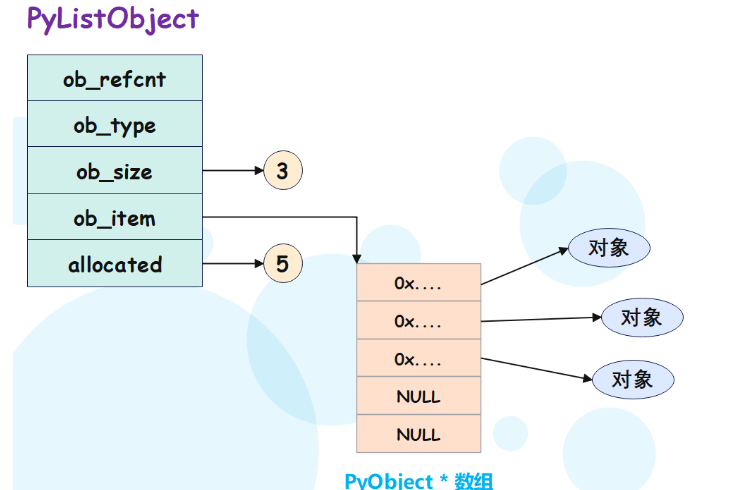
这便是列表的底层结构示意图，我们看到底层数组的长度为5，说明此时列表的容量为5，但是里面只有3个PyObject *指针，说明列表的ob_size是3，或者说列表里面此时有3个元素。

如果这个时候我们往列表中append一个元素，那么会将这个新元素设置在数组索引为ob_size的位置、或者说第四个位置。一旦设置完，ob_size会自动加1，因为ob_size要和列表的长度保持一致。

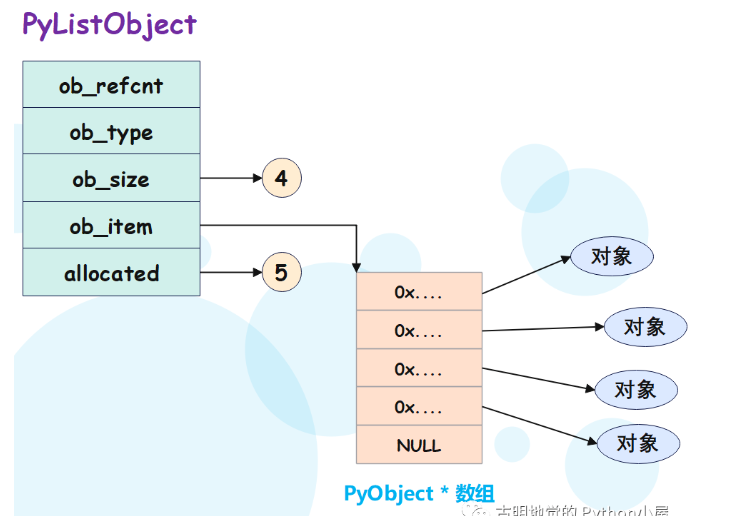
如果此时再往列表中append一个元素的话，那么还是将新元素设置在索引为ob_size的位置，此时也就是第5个位置。

列表的容量是5，但此时长度也达到了5，这说明当下一次append的时候，已经没有办法再容纳新的元素了。因为此时列表的长度、或者说元素个数已经达到了容量。当然最直观的还是这里的底层数组，很明显全都占满了。那这个时候如果想再接收新的元素的话，要怎么办呢？显然只能扩容了。

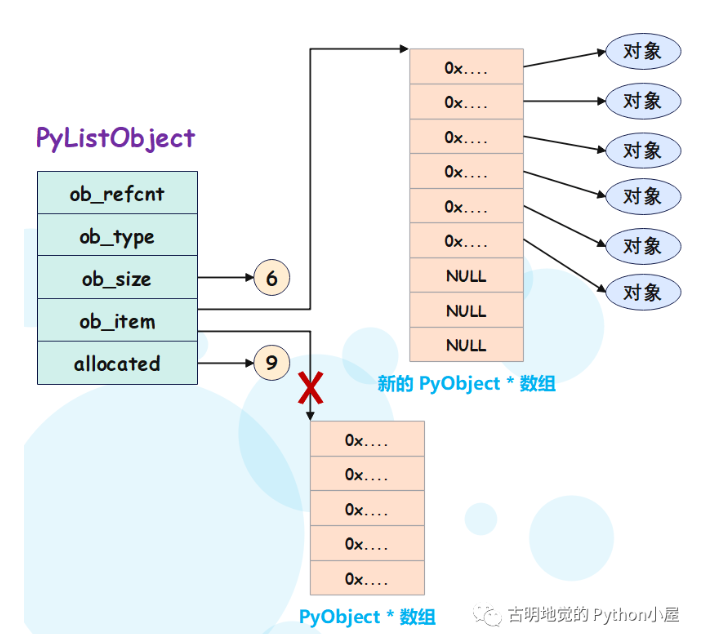

原来的容量是5个，长度也是5个，当再来一个新元素的时候由于没有位置了，所以要扩容。但是扩容的时候肯定会将容量申请的大一些、即底层数组申请的长一些。

总之申请的新的底层数组长度是9，那么说明列表的容量就变成了9。然后将原来数组中的PyObject *按照顺序依次拷贝到新的数组里面，再让ob_item指向新的数组。最后将要添加的新元素设置在新的数组中索引为ob_size的位置、即第6个位置，然后将ob_size加1即可，此时ob_size变成了6。

以上便是列表底层在扩容的时候所经历的过程。

而且我们知道，列表在append之后地址是不变的，至于原因上面的几张图已经解释的很清楚了。

如果长度没有达到容量，那么append其实就是往底层数组中设置了一个新元素；如果达到容量了，那么会扩容，但扩容只是申请一个新的指针数组，然后让ob_item重新指向罢了。

所以底层的指针数组会变，但是PyListObject结构体实例本身是没有变化的。因此列表无论是append、extend、pop、insert等等，只要是在本地操作，那么它的地址是不会变化的。

In [8]:
lst = []
allocated = 0
print("此时容量是: 0")

for item in range(100):
    lst.append(item)  # 添加元素
    
    # 计算ob_size
    ob_size = len(lst)

    # 判断ob_size和当前的容量
    if ob_size > allocated:
        #lst的大小减去空列表的大小, 再除以8显然就是容量的大小
        #因为不管你有没有用, 容量已经分配了
        allocated = (lst.__sizeof__() - [].__sizeof__()) // 8
        print(f"列表扩容啦, 新的容量是: {allocated}")

此时容量是: 0
列表扩容啦, 新的容量是: 4
列表扩容啦, 新的容量是: 8
列表扩容啦, 新的容量是: 16
列表扩容啦, 新的容量是: 25
列表扩容啦, 新的容量是: 35
列表扩容啦, 新的容量是: 46
列表扩容啦, 新的容量是: 58
列表扩容啦, 新的容量是: 72
列表扩容啦, 新的容量是: 88
列表扩容啦, 新的容量是: 106


需要注意的是，会影响列表元素个数的操作（append、extend、insert、pop等等），在执行前都会先执行一下list_resize进行容量检测。

如果计算之后的ob_size、也就是newsize和allocated之间的关系是匹配的，即 allocated//2 <= newsize <= allocated，那么只需要将ob_size的大小更新为newsize即可。如果不匹配，那么还要进行扩容

介绍完扩容，再来介绍缩容，因为列表元素个数要是减少到和容量不匹配的话，也要进行缩容。



举个生活中的例子，假设你租了10间屋子用于办公，显然你要付10间屋子的房租，不管你有没有用，一旦租了肯定是要付钱的。同理底层数组也是一样，只要你申请了，不管有没有元素，内存已经占用了。

但有一天你用不到10间屋子了，假设要用8间或者9间，那么会让剩余的屋子闲下来。但由于退租比较麻烦，并且只闲下来一两间屋子，所以干脆就不退了，还是会付10间屋子的钱，这样没准哪天又要用的时候就不用重新租了。

对于列表也是如此，在删除元素(相当于屋子不用了)的时候，如果发现长度还没有低于容量的一半，那么也不会缩容。但反之就要缩容了，比如屋子闲了8间，也就是只需要两间屋子就足够了，那么此时肯定要退租了，闲了8间，可能会退掉6间。

In [2]:
lst = [0] * 1000
print(
    len(lst), (lst.__sizeof__() - [].__sizeof__()) // 8
)  # 1000 1000

# 删除500个元素, 此时长度或者说ob_size就为500
lst[500:] = []
# 但是ob_size还是达到了容量的一半, 所以不会缩容
print(
    len(lst), (lst.__sizeof__() - [].__sizeof__()) // 8
)  # 500 1000

#如果再删除一个元素的话, 那么就要进行缩容了
#因为ob_size变成了499, 小于1000 // 2
#缩容之后容量计算公式
print(499 + (499 >> 3) + (3 if 499 < 9 else 6))  # 567

#测试一下, 删除一个元素, 看看会不会按照我们期待的规则进行缩容
lst.pop()
print(
    len(lst), (lst.__sizeof__() - [].__sizeof__()) // 8
)  # 499 567

1000 1000
500 1000
567
499 567


## 列表行为

### append 追加元素

In [7]:
#append 的逻辑，所谓插入、追加本质上都是通过索引设置元素
# 创建一个列表，这里是通过Python/C API创建的
lst = [1, 2, 3, 4]
print(lst)

# 往列表尾部追加一个元素，此时是在本地操作的，返回值为None
# 但是列表被改变了
lst.append(5)
print(lst)

[1, 2, 3, 4]
[1, 2, 3, 4, 5]


### 获取元素

In [8]:
val_1 = lst[1]
print(val_1)
val_2=lst[1:3]
print(val_2)

2
[2, 3]


### 设置元素

In [9]:
lst = [1, 2, 3, 4, 5, 6, 7, 8]

#首先通过切片进行设置的话
#右值一定要是一个可迭代对象
lst[0: 3] = [11, 22, 33]
# 会将lst[0]设置为11、lst[1]设置为22、lst[2]设置为33
print(lst)  # [11, 22, 33, 4, 5, 6, 7, 8]

[11, 22, 33, 4, 5, 6, 7, 8]


In [10]:
#而且它们的长度是可以不相等的
#这里表示将[0: 3]的元素设置为[1, 2], lst[0]设置成1, lst[1]设置成2
#问题来了, lst[2]咋办? 
#由于右值中已经没有元素与之匹配了, 那么lst[2]就会被删掉
lst[0: 3] = [1, 2]
print(lst)  # [1, 2, 4, 5, 6, 7, 8]

[1, 2, 4, 5, 6, 7, 8]


In [11]:
#所以如果想删除[0: 3]的元素，那么只需要执行lst[0: 3] = []即可
#因为[]里面没有元素能与之匹配，所以lst中[0: 3]的位置由于匹配不到
#那么相当于执行了删除操作。当然由于Python的动态特性，
#lst[0: 3] = []、lst[0: 3] = ()、lst[0: 3] = ""等等都是可以的
lst[0: 3] = ""
print(lst)  # [5, 6, 7, 8]
#实际上我们del lst[0]的时候，就是执行了lst[0: 1] = []

[5, 6, 7, 8]


In [12]:
# 当然如果右值元素多的话也是可以的
lst[0: 1] = [1, 2, 3, 4]
print(lst)  # [1, 2, 3, 4, 6, 7, 8]
#lst[0]匹配1很好理解, 但是此时左边已经结束了
#所以剩余的元素会依次插在后面

[1, 2, 3, 4, 6, 7, 8]


In [13]:
#然后重点来了, 如果切片有步长的话, 那么两边一定要匹配
#由于此时lst中有8个元素, lst[:: 2]会得到4个元素
#那么右边的可迭代对象的长度也是4
lst[:: 2] = ['a', 'b', 'c', 'd']
print(lst)  # ['a', 2, 'b', 4, 'c', 7, 'd']

# 但是，如果长度不一致
try:
    lst[:: 2] = ['a', 'b', 'c']
except Exception as e:
    # 显然会报错
    print(e)  # attempt to assign sequence of size 3 to extended slice of size 4

['a', 2, 'b', 4, 'c', 7, 'd']
attempt to assign sequence of size 3 to extended slice of size 4


### 插入元素

In [14]:
lst = [1, 2, 3, 4, 5, 6, 7, 8]
lst.insert(0, 'x')
print(lst)

['x', 1, 2, 3, 4, 5, 6, 7, 8]


### pop弹出元素

In [15]:
#pop默认是从尾部弹出元素的，因为如果不指定索引的话，默认是-1。当然我们也可以指定索引，弹出指定索引对应的元素。
print(lst.pop())
print(lst)

8
['x', 1, 2, 3, 4, 5, 6, 7]


### index查询元素的索引

In [18]:
#index方法可以接收一个元素，然后返回该元素首次出现的位置。当然还可以额外指定一个start和end，表示查询的范围。
print(lst.index(3))

3


### count查询指定元素出现的次数

In [3]:
#列表有一个 count 方法，可以计算出某个元素出现的次数。
lst = ['a','a','a']
print(lst.count('a'))  # 3

3


### remove删除指定元素

In [20]:
# 根据元素的值删除第一个出现的元素
lst=[1,2,3,4,5,6]
lst.remove(4)
print(lst)

[1, 2, 3, 5, 6]


 remove函数的底层实现，说白了就是一层 for 循环，依次比较列表的每个元素和待删除元素是否相等。如果出现了相等的元素，则删除，然后直接返回，因为只删除一个；当整个循环遍历结束也没有发现满足条件的元素，那么报错，待删除元素不存在。

### reverse翻转列表

In [21]:
lst=['a','b','c']
lst.reverse()
print(lst)

['c', 'b', 'a']


### 两个列表相加

In [22]:
lst_1=['a','b','c','d',1]
lst_2=[1,2,3,4,5]
lst=lst_1+lst_2
print(lst)

['a', 'b', 'c', 'd', 1, 1, 2, 3, 4, 5]


### 判断某个元素是否在列表中

In [23]:
[1,2,3] in lst_2

False

In [24]:
2 in lst_2

True

### 列表的深浅拷贝

In [1]:
lst = [[]]

# 默认是浅拷贝, 这个过程会创建一个新列表
# 但我们说列表l里面都是指针，因此只会将里面的指针拷贝一份
# 但是指针指向的内存并没有拷贝
lst_cp = lst.copy()

# 两个对象的地址是一样的
print(id(lst[0]), id(lst_cp[0]))  

# 操作lst[0], 会改变lst_cp[0]
lst[0].append(123)
print(lst, lst_cp)  # [[123]] [[123]]

# 操作lst_cp[0], 会改变lst[0]
lst_cp[0].append(456)
print(lst, lst_cp)  # [[123, 456]] [[123, 456]]

2501324282112 2501324282112
[[123]] [[123]]
[[123, 456]] [[123, 456]]


In [2]:
lst = [[], 1, 2, 3]
val = lst[0]
lst_cp = lst[0: 1]

print(lst[0] is val is lst_cp[0])  # True
# 此外，lst[:]等价于lst.copy()

True


所以lst.copy()就是创建了一个新列表，然后把元素拷贝了过去，只不过元素都是指针。因为只是拷贝指针，没有拷贝指针指向的对象(内存)，所以它们指向的是同一个对象。

但如果我们就想在拷贝指针的同时也拷贝指针指向的对象呢？答案是使用一个叫copy的模块。

In [3]:
import copy

lst = [[]]
# 此时拷贝的时候，就会把指针指向的对象也给拷贝一份
lst_cp1 = copy.deepcopy(lst)
lst_cp2 = lst[:]

lst_cp2[0].append(123)
print(lst)  # [[123]]
print(lst_cp1)  # [[]]

# lst[:]这种方式也是浅拷贝, 所以修改lst_cp2[0], 也会影响lst[0]
# 但是没有影响lst_cp1[0], 证明它们是相互独立的, 因为指向的是不同的对象

[[123]]
[[]]


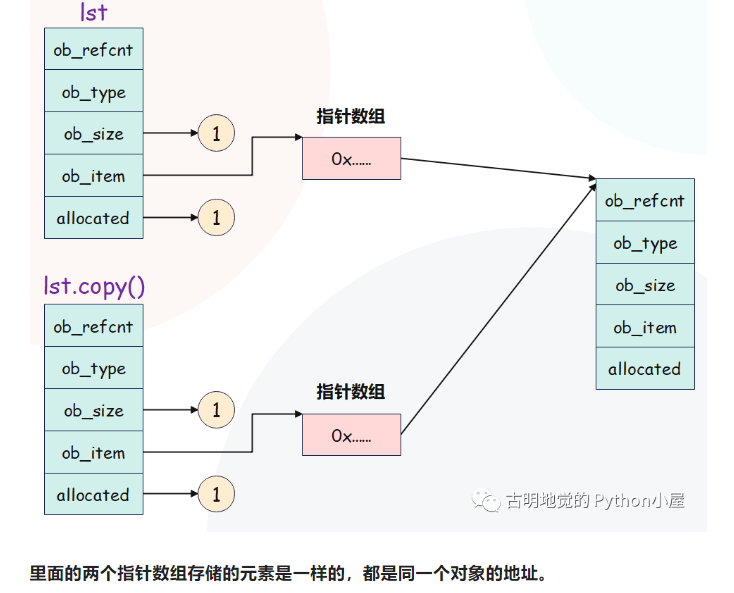

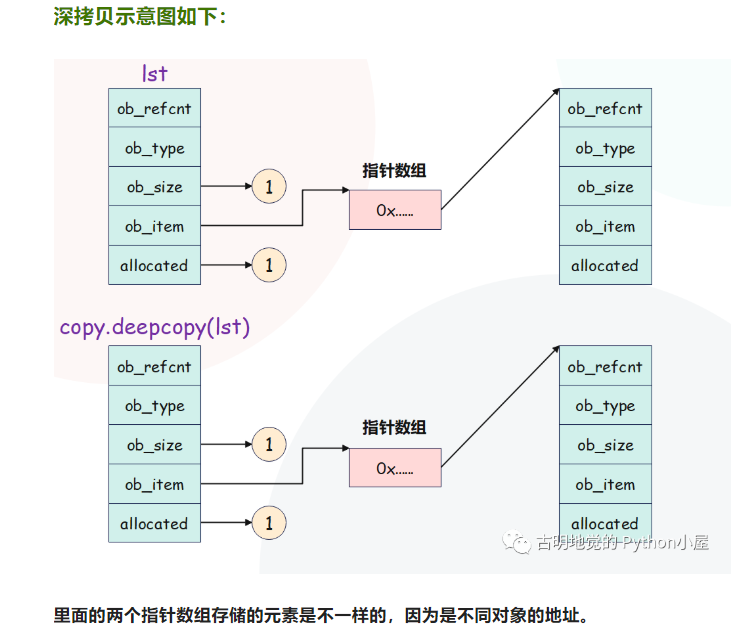

copy.deepcopy虽然在拷贝指针的同时会将指针指向的对象也拷贝一份，但这仅仅是针对于可变对象，对于不可变对象是不会拷贝的。

https://blog.csdn.net/weixin_45037429/article/details/105733527

https://www.bilibili.com/video/BV1eE411P7Vh?spm_id_from=333.337.search-card.all.click